# Final Project

In [6]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
import time
import pickle
import matplotlib.pyplot as plt
import os

from keras.wrappers.scikit_learn import KerasRegressor
from typing import Final
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'  # Suppress TF AVX info message
plt.rcParams['figure.figsize'] = [12, 6]  # type: ignore # make inline plots bigger


## Data Preprocessing

In [8]:
BUILD_DATA_FROM_RAW = False

if BUILD_DATA_FROM_RAW: # Build the complete dataset
    gdp_raw = pd.read_excel('gdp.xlsx').set_axis(
        [
            'county', '2017', '2018',
            '2019', '2020', 'rank 2018',
            'percent change 2018', 'percent change 2019',
            'percent change 2020', 'rank 2020'
        ],
        axis=1,
        inplace=False
    )

    gdp_clean: pd.DataFrame = gdp_raw.drop(
        columns=[
            'rank 2018', '2017', '2018', '2020',
            'rank 2020', 'percent change 2018',
            'percent change 2019'
        ],
        inplace=False).iloc[5:3222]

    state_names = pd.read_csv('us-counties-2020.csv')['state'].unique()
    counties_df = pd.read_csv('complete.csv')

    # Initialize empty columns
    counties_df['2019 raw GDP'] = np.nan  # iloc = 5
    counties_df['percent change 2020'] = np.nan  # iloc = 6

    # Rearrange the GDP data so that it's ordered by counties
    curr_state = None
    for index, row in gdp_clean.iterrows():
        if row[0] in state_names:
            curr_state = row[0]
            continue
        else:
            row_index = counties_df.index[(counties_df['state'] == curr_state) & (
                counties_df['county'] == row[0])].tolist()
            counties_df.iloc[[row_index], [5]] = row[1]  # type: ignore
            counties_df.iloc[[row_index], [6]] = row[2]  # type: ignore

    # Datatype conversion
    counties_df['2019 raw GDP'] = counties_df['2019 raw GDP'].astype('float64')
    counties_df['percent change 2020'] = counties_df['percent change 2020'].astype(
        'float64')
else: # Use the dataset we saved from the code in the if block above
    counties_df = pd.read_csv('The FINAL dataset.csv')

In [ ]:
# One hot encoding for the state names
encoded_state_names = pd.get_dummies(counties_df['state'])
counties_df = counties_df.drop(columns=['state'])\
                        .join(encoded_state_names)\
                        .dropna(axis='index', how='any')
print(counties_df)

## Building the model

In [10]:
# Setup some constants
DEFAULT_LEARNING_RATE: Final[float] = 0.1
DEFAULT_EPOCHS: Final[int] = 500

In [11]:
def BuildDefaultModel():
    SGD_optimizer: Final = tf.keras.optimizers.SGD(
        learning_rate=DEFAULT_LEARNING_RATE)
    lossFunction = tf.keras.losses.MeanSquaredError()

    model: keras.Sequential = keras.Sequential([
        keras.Input(shape=(59)),
        tf.keras.layers.Dense(
            units=30, activation=tf.nn.relu, name='hidden_layer_1'),
        tf.keras.layers.Dense(
            units=30, activation=tf.nn.relu, name='hidden_layer_2'),
        tf.keras.layers.Dense(
            units=15, activation=tf.nn.relu, name='hidden_layer_3'),
        tf.keras.layers.Dense(
            units=5, activation=tf.nn.relu, name='hidden_layer_4'),
        tf.keras.layers.Dense(units=1, activation=tf.nn.relu, name='output'),
    ], name='Default_COVID_Regressor')

    model.compile(loss=lossFunction, optimizer=SGD_optimizer,
                  metrics=['MeanSquaredError'])
    return model


defaultCovidRegressor = BuildDefaultModel()
print(defaultCovidRegressor.summary())


Model: "Default_COVID_Regressor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden_layer_1 (Dense)      (None, 30)                1800      
                                                                 
 hidden_layer_2 (Dense)      (None, 30)                930       
                                                                 
 hidden_layer_3 (Dense)      (None, 15)                465       
                                                                 
 hidden_layer_4 (Dense)      (None, 5)                 80        
                                                                 
 output (Dense)              (None, 1)                 6         
                                                                 
Total params: 3,281
Trainable params: 3,281
Non-trainable params: 0
_________________________________________________________________
None


In [12]:
# Build the input dataset X
input_attributes = counties_df.drop(
    columns=['percent change 2020', 'county'], inplace=False)

input_attributes['2019 raw GDP'] = input_attributes['2019 raw GDP'].astype(
    'float64')
input_attributes['cases'] = input_attributes['cases'].astype('int32')

input_attributes['Positivity Rate'] = input_attributes['cases'] / \
    input_attributes['2020 population']
input_attributes['Death Rate'] = input_attributes['deaths'] / \
    input_attributes['2020 population']

input_attributes.drop(columns=['cases', 'deaths'], inplace=True)

# Scale the raw GDP and population individually after the positivity rates
# Otherwise the rates also get normalized
gdp_scaler = MinMaxScaler()
population_scaler = MinMaxScaler()

input_attributes['2019 raw GDP'] = gdp_scaler.fit_transform(
    np.array(input_attributes['2019 raw GDP']).reshape(-1, 1))
input_attributes['2020 population'] = population_scaler.fit_transform(
    np.array(input_attributes['2020 population']).reshape(-1, 1))

print(input_attributes)


      2020 population  2019 raw GDP  Alabama  Alaska  Arizona  Arkansas  \
0            0.005855      0.002164        1       0        0         0   
1            0.023301      0.010113        1       0        0         0   
2            0.002481      0.001011        1       0        0         0   
3            0.002185      0.000516        1       0        0         0   
4            0.005875      0.001300        1       0        0         0   
...               ...           ...      ...     ...      ...       ...   
3240         0.004181      0.005201        0       0        0         0   
3241         0.002298      0.003199        0       0        0         0   
3242         0.002007      0.001227        0       0        0         0   
3243         0.000727      0.000472        0       0        0         0   
3244         0.000642      0.000434        0       0        0         0   

      California  Colorado  Connecticut  Delaware  ...  Utah  Vermont  \
0              0         0

In [13]:
# Normalize y because NN only outputs from 0 to 1
y_scaler = MinMaxScaler()
y_vals = y_scaler.fit_transform(
    np.array(counties_df['percent change 2020']).reshape(-1, 1)
)
y_vals = y_vals.reshape(y_vals.shape[0])


In [14]:
# Train test split
X_Train, X_Test, y_Train, y_Test = train_test_split(
    input_attributes,
    y_vals,
    test_size=0.1,
    random_state=44
)


In [15]:
# Compile and Train the default model
TRAIN_DEFAULT = False

if TRAIN_DEFAULT:
    startTime = time.time()
    defaultCovidRegressor.fit(
        x=X_Train,
        y=y_Train,
        epochs=DEFAULT_EPOCHS,
        validation_data=(X_Test, y_Test)
    )
    endTime = time.time()    
    predicted_y: np.ndarray = defaultCovidRegressor.predict(X_Test)

    print(f'Training took {endTime-startTime} seconds')
    print(f'MSE of test set is: {mean_squared_error(predicted_y, y_Test)}')


In [17]:
def generateValidationData(inputDF: pd.DataFrame,
                           expectedOutputs: np.ndarray,
                           trainIndexes: np.ndarray,
                           testIndexes: np.ndarray):
    X_Train = inputDF.iloc[trainIndexes]
    X_Test = inputDF.iloc[testIndexes]

    y_Train = expectedOutputs[trainIndexes]
    y_Test = expectedOutputs[testIndexes]

    return X_Train, X_Test, y_Train, y_Test


In [18]:
# Do 10-fold validation
# This is slow so skip if necessary
RUN_K_FOLD = False
if RUN_K_FOLD:
    KFolder = KFold(n_splits=10)
    mseScores: list[float] = []
    accuracyScores: list[float] = []

    for trainIndexes, testIndexes in KFolder.split(input_attributes):
        X_Train, X_Test, y_Train, y_Test = generateValidationData(
            input_attributes,
            y_vals,
            trainIndexes,
            testIndexes
        )

        defaultCovidRegressor.fit(
            x=X_Train, y=y_Train,
            epochs=DEFAULT_EPOCHS,
            validation_data=(X_Test, y_Test)
        )

        predicted_y: np.ndarray = defaultCovidRegressor.predict(X_Test)

        mseScores.append(mean_squared_error(y_Test, predicted_y))
        print(f'MSE Loss: {mseScores}\nAverage MSE is: {np.average(mseScores)}')


## RandomSearch Hyperparameter Tuning

In [ ]:
# build generic model that accepts parameters

def BuildModel(numNodesLayer1=30,
               numNodesLayer2=30,
               numNodesLayer3=15,
               numNodesLayer4=5,
               learningRate=DEFAULT_LEARNING_RATE):
    SGD_optimizer: Final = tf.keras.optimizers.SGD(learning_rate=learningRate)
    lossFunction: Final = tf.keras.losses.MeanSquaredError()

    model: keras.Sequential = keras.Sequential(
        [
            keras.Input(shape=(59)),
            tf.keras.layers.Dense(
                units=numNodesLayer1, activation=tf.nn.relu, name='hidden_layer_1'),
            tf.keras.layers.Dense(
                units=numNodesLayer2, activation=tf.nn.relu, name='hidden_layer_2'),
            tf.keras.layers.Dense(
                units=numNodesLayer3, activation=tf.nn.relu, name='hidden_layer_3'),
            tf.keras.layers.Dense(
                units=numNodesLayer4, activation=tf.nn.relu, name='hidden_layer_4'),
            tf.keras.layers.Dense(
                units=1, activation=tf.nn.relu, name='output'),
        ],
        name='COVID_Regressor'
    )

    model.compile(
        loss=lossFunction,
        optimizer=SGD_optimizer,
        metrics=['mse']
    )
    return model


wrappedCovidRegressor = KerasRegressor(build_fn=BuildModel)

# parameters passed to BuildModel(...)
param_grid = dict(
    nb_epoch=np.array(list(range(500, 1000))),
    learningRate=np.array([0.03, 0.05, 0.1, 0.2]),
    numNodesLayer1=np.array([13, 23, 30, 35]),
    numNodesLayer2=np.array([7, 10, 20, 30]),
    numNodesLayer3=np.array([10, 15, 17]),
    numNodesLayer4=np.array([5, 6, 7])
)

random_search = RandomizedSearchCV(estimator=wrappedCovidRegressor,
                                   param_distributions=param_grid,
                                   n_jobs=-1,
                                   cv=10)

# Extremely slow, do not run this repeatedly
random_search_result = random_search.fit(
    X_Train,
    y_Train,
    validation_data=(X_Test, y_Test)
)


In [25]:
tuning_results = dict(random_search_result.best_params_)
best_num_epochs = tuning_results['nb_epoch']
print(tuning_results)

del tuning_results['nb_epoch'] # delete this one so tuning_results can be used as kwargs

{'numNodesLayer4': 7, 'numNodesLayer3': 10, 'numNodesLayer2': 7, 'numNodesLayer1': 30, 'nb_epoch': 528, 'learningRate': 0.2}


In [ ]:
tunedModel = BuildModel(**tuning_results)

# Compile and Train the default model
startTime = time.time()
history = tunedModel.fit(
    x=X_Train,
    y=y_Train,
    epochs=best_num_epochs,
    validation_data=(X_Test, y_Test)
)
endTime = time.time()

print(f'Training took {endTime-startTime} seconds')


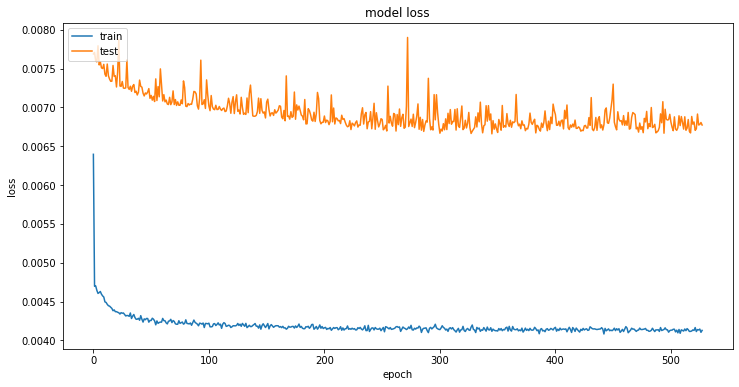

In [27]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
# plt.savefig('loss.png', dpi=150)
plt.show()

In [ ]:
# Save the model and scalers for the backend to load

pkl_filename = 'packaged_model.pkl'
with open(pkl_filename, 'wb') as f:
    pickle.dump(tunedModel, f)

gdp_scaler_file = 'gdp_scaler.pkl'
with open(gdp_scaler_file, 'wb') as f:
    pickle.dump(gdp_scaler, f)

population_scaler_file = 'population_scaler.pkl'
with open(population_scaler_file, 'wb') as f:
    pickle.dump(population_scaler, f)

y_scaler_file = 'y_scaler.pkl'
with open(y_scaler_file, 'wb') as f:
    pickle.dump(y_scaler, f)

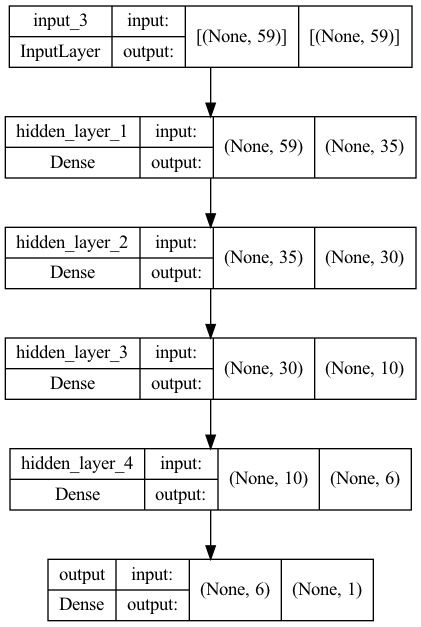

In [2]:
import pickle
from keras.utils.vis_utils import plot_model
model = pickle.load(open('packaged_model.pkl','rb'))
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

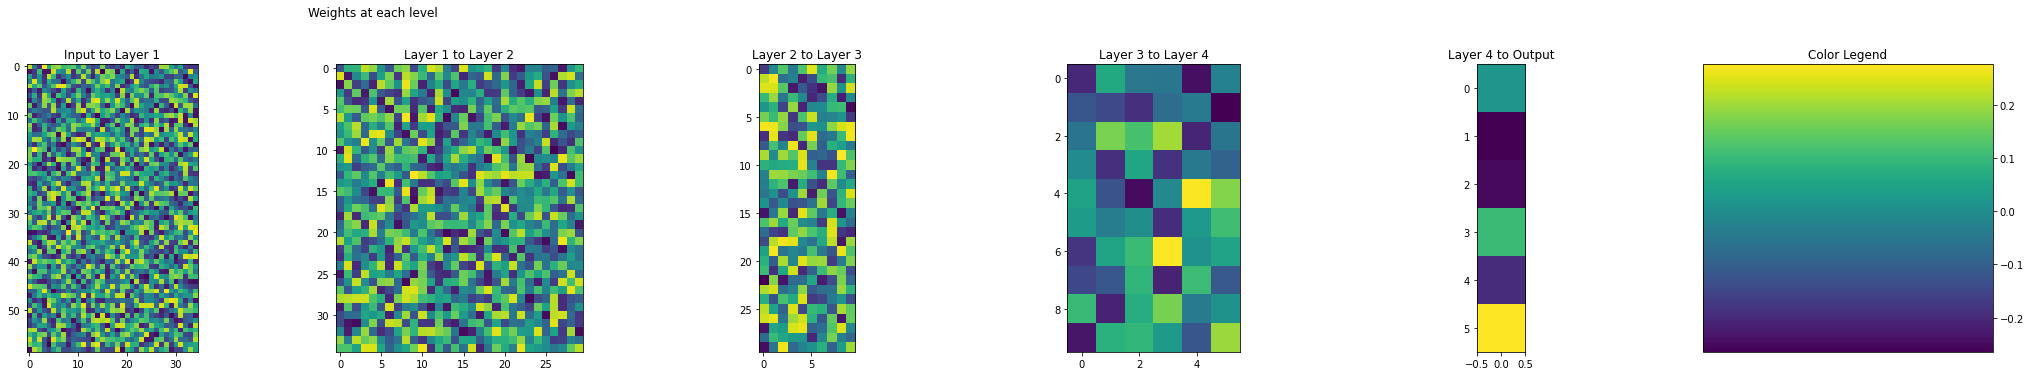

In [60]:
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1, 6)


fig.subplots_adjust(bottom=0.5, right=2, top=0.9)
fig.suptitle('Weights at each level')


im = ax1.imshow(model.get_weights()[0])
ax1.title.set_text('Input to Layer 1')
ax2.imshow(model.get_weights()[2])
ax2.title.set_text('Layer 1 to Layer 2')
ax3.imshow(model.get_weights()[4])
ax3.title.set_text('Layer 2 to Layer 3')
ax4.imshow(model.get_weights()[6])
ax4.title.set_text('Layer 3 to Layer 4')
ax5.imshow(model.get_weights()[8])
ax5.title.set_text('Layer 4 to Output')

fig.colorbar(im, cax=ax6)
ax6.title.set_text('Color Legend')
